In [1]:
!pip install cartopy

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

%matplotlib inline

2023-12-04 22:27:35.803893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 22:27:35.803931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 22:27:35.805062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 22:27:35.810403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 22:27:36.681631: W tensorflow/compiler/tf2

In [2]:
!ls

features_selection  LSTM_torch.ipynb  pipeline.py
LSTM.ipynb	    pipeline.ipynb    README.md


In [2]:
# Replace 'your_file.csv' with the actual filename
file_path = [f'features_selection/data/features_{i}_19402023.csv' for i in range(5)]

def load_and_preprocess_data(file_path):
    """
    Load the dataset from the given file path and perform preprocessing steps.
    """
    if isinstance(file_path, list):
      df = pd.read_csv(file_path[0])
      for i in file_path[1:]:
        df = pd.concat([df, pd.read_csv(i)], axis=0)
      df = df.drop(['g', 'sst'], axis=1)
    else:
      df = pd.read_csv(file_path)
      df.sort_values(by=['time','latitude','longitude'])
      df = df.drop(["g"], axis=1)
      df = df.interpolate()
      df = df.dropna()

      for col in df.select_dtypes(include='float64').columns:
        df[col] = df[col].astype('float32', copy=False)

    return df

df = load_and_preprocess_data(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3594276 entries, 0 to 718854
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   time       object 
 1   latitude   float64
 2   longitude  float64
 3   10u        float64
 4   10v        float64
 5   100u       float64
 6   100v       float64
 7   msl        float64
 8   swvl1      float64
 9   geo500     float64
 10  2t         float64
dtypes: float64(10), object(1)
memory usage: 329.1+ MB


In [3]:
df

,time,latitude,longitude,10u,10v,100u,100v,msl,swvl1,geo500,2t
0,1940-01-01 00:00:00,38.0,125.00,0.419251,-6.994049,0.539322,-7.767197,102701.690,0.000002,54024.832,-2.504486
1,1940-01-01 00:00:00,38.0,125.25,0.267883,-5.567291,0.401627,-6.972275,102700.440,0.182467,54007.832,-4.463470
2,1940-01-01 00:00:00,38.0,125.50,0.320618,-4.622955,0.482681,-6.185165,102706.690,0.229876,53989.582,-6.065033
3,1940-01-01 00:00:00,38.0,125.75,0.107727,-4.240143,0.275650,-5.673447,102706.190,0.208132,53971.082,-6.861908
4,1940-01-01 00:00:00,38.0,126.00,0.156555,-3.693268,0.290298,-5.080673,102703.690,0.293429,53953.582,-7.449799
...,...,...,...,...,...,...,...,...,...,...,...
718850,2023-11-19 12:00:00,34.0,129.00,10.564636,-3.080109,11.930634,-3.466751,101845.875,0.000005,55508.690,16.389801
718851,2023-11-19 12:00:00,34.0,129.25,10.969910,-2.972687,12.307587,-3.304642,101832.625,0.000005,55488.190,16.299957
718852,2023-11-19 12:00:00,34.0,129.50,10.767761,-2.702179,12.258759,-3.010696,101818.625,0.000005,55467.940,16.333160
718853,2023-11-19 12:00:00,34.0,129.75,11.442566,-2.366242,12.838837,-2.653275,101801.625,0.000005,55448.690,16.514801


In [4]:
df_av_month = df.copy()
df_av_month['time'] = pd.to_datetime(df_av_month['time']).dt.to_period('M')
df_av_month = df_av_month.groupby(['time','latitude','longitude']).mean().reset_index().sort_values(by=['time', 'latitude', 'longitude'])
df_av_month

,time,latitude,longitude,10u,10v,100u,100v,msl,swvl1,geo500,2t
0,1940-01,34.0,125.00,3.109276,-6.966926,3.416429,-7.617951,102041.055500,0.000002,53475.03180,3.971347
1,1940-01,34.0,125.25,3.254979,-7.084505,3.583031,-7.763556,102020.430500,0.000002,53457.15680,3.998691
2,1940-01,34.0,125.50,3.445702,-7.237923,3.785765,-7.901642,101997.530500,0.000002,53440.45680,4.070566
3,1940-01,34.0,125.75,3.635838,-7.284895,4.025413,-8.021954,101975.205500,0.000002,53422.65680,4.018027
4,1940-01,34.0,126.00,3.873924,-7.324837,4.305492,-8.090411,101950.680500,0.000002,53405.38180,4.145175
...,...,...,...,...,...,...,...,...,...,...,...
359494,2023-11,38.0,129.00,6.074238,0.989002,7.530390,1.212111,101801.609375,0.000004,55013.37825,11.436935
359495,2023-11,38.0,129.25,7.215717,-0.111340,8.244989,-0.191332,101796.859375,0.000004,54990.31575,12.330246
359496,2023-11,38.0,129.50,7.551777,-0.940319,8.650873,-1.085985,101783.203125,0.000004,54970.90950,12.700607
359497,2023-11,38.0,129.75,7.590595,-1.631847,8.827387,-1.780443,101771.328125,0.000004,54954.50325,12.885666


In [5]:
df = df_av_month

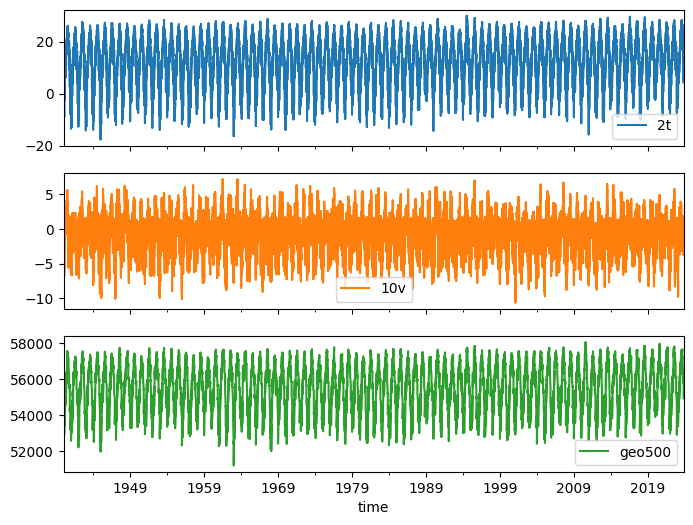

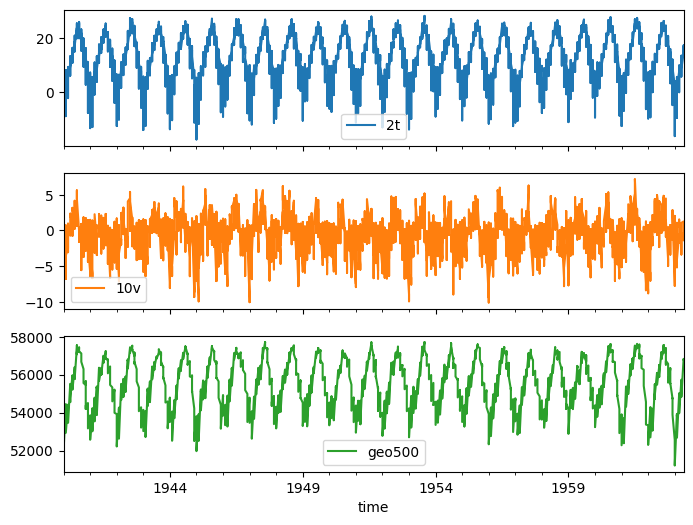

In [14]:
#date_time = pd.to_datetime(df_av_month['time'], format='%Y.%m')

plot_cols = ['2t', '10v', 'geo500']
plot_features = df_av_month[plot_cols]
plot_features.index = df_av_month['time']
_ = plot_features.plot(subplots=True)

plot_features = df_av_month[plot_cols][:100000]
plot_features.index = df_av_month['time'][:100000]
_ = plot_features.plot(subplots=True)

In [6]:
from tqdm import tqdm

# Extract relevant columns
lat = df['latitude'].unique()
print(f"Latitude: {lat.shape}")
lon = df['longitude'].unique()
print(f"Longitude: {lon.shape}")
features = ['10u', '10v','100u','100v','msl','swvl1','geo500','2t']
print(f"Features: {len(features)}")
timesteps = df['time'].unique()
print(f"Timestep: {timesteps.shape}")

# Create an empty 4D array
shape = (len(timesteps), len(lat), len(lon), len(features))
data_array = np.zeros(shape)

# Fill the array with data from the DataFrame
for i, lat_val in tqdm(enumerate(lat)):
  for j, lon_val in enumerate(lon):
    for k, feature in enumerate(features):
      subset = df[(df['longitude'] == lon_val) & (df['latitude'] == lat_val)]

      # Ensure that the subset has the same length as 'timesteps'
      assert len(subset) == len(timesteps), f"Warning: Length of subset ({len(subset)}) does not match timesteps ({len(timesteps)}) for lon={lon_val}, lat={lat_val}"

      data_array[:, i, j, k] = subset[feature].values

# Now, data_array is a 4D NumPy array with the shape (time, features, lat, lon)
f"Shape dataset : (Timesteps: {data_array.shape[0]}, Latitude: {data_array.shape[1]}, Longitude: {data_array.shape[2]}, Features: {data_array.shape[3]})"

Latitude: (17,)
Longitude: (21,)
Features: 8
Timestep: (1007,)


0it [00:00, ?it/s]

17it [00:01, 11.89it/s]


'Shape dataset : (Timesteps: 1007, Latitude: 17, Longitude: 21, Features: 8)'

In [7]:
data_array.shape

(1007, 17, 21, 8)

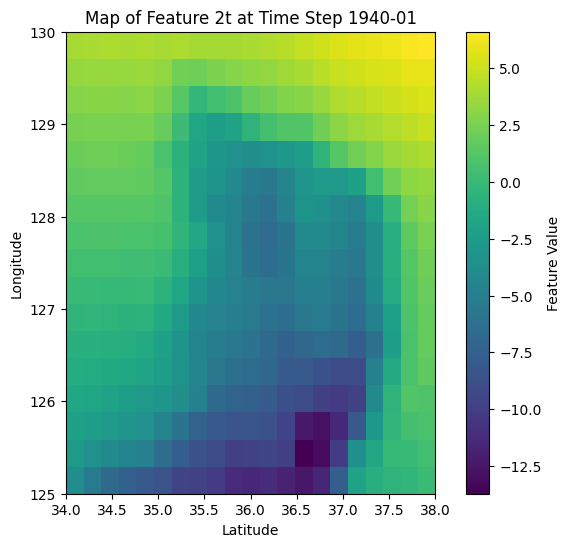

In [8]:
import matplotlib.pyplot as plt

# Example: Plotting a specific feature at a specific time step
feature_index = -1
time_step = 0

plt.imshow(data_array[time_step, :, :, feature_index], extent=(lat.min(), lat.max(), lon.min(), lon.max()))
plt.colorbar(label='Feature Value')
plt.title(f'Map of Feature {features[feature_index]} at Time Step {timesteps[time_step]}')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

Shape of X: (17, 21)
Shape of Y: (17, 21)
Shape of C: (17, 21)


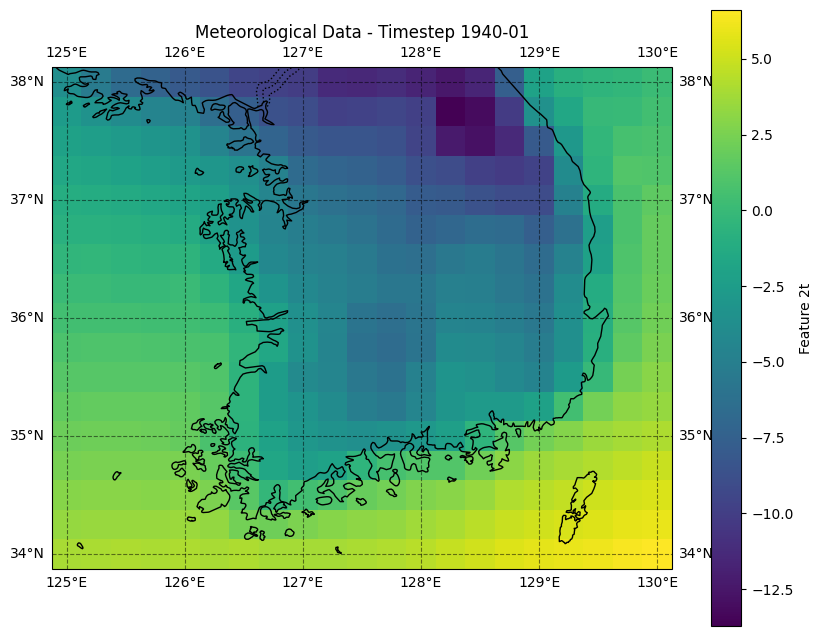

In [9]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np

def plot_meteorological_data(lat, lon, data, feature_index, timestep, title="Meteorological Data"):
    """
    Plot meteorological data on a map using Cartopy.

    Parameters:
    - lon: 1D array, longitude values
    - lat: 1D array, latitude values
    - data: 4D array, meteorological data (time, features, lat, lon)
    - feature_index: int, the index of the meteorological feature being plotted
    - timestep: int, the index of the timestep to be plotted
    - title: str, title of the plot (default is "Meteorological Data")
    """
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))

    # Reshape data for pcolormesh
    X, Y = np.meshgrid(lon, lat)
    C = data[timestep, :, :, feature_index]

    print(f"Shape of X: {X.shape}")
    print(f"Shape of Y: {Y.shape}")
    print(f"Shape of C: {C.shape}")

    # Plot the meteorological data
    im = ax.pcolormesh(X, Y, C, cmap='viridis', transform=ccrs.PlateCarree(), shading='auto')

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

    # Add gridlines
    ax.gridlines(draw_labels=True, linestyle='--', color='black', alpha=0.5)

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, label=f"Feature {features[feature_index]}")

    # Set plot title
    plt.title(f"{title} - Timestep {timesteps[time_step]}")

    # Show the plot
    plt.show()

# Example usage:
plot_meteorological_data(lat, lon, data_array, -1, 0)


In [10]:
def split_data(data):
    """
    Function to split time series data into train, val and test set.
    Respectively : 70% / 20% / 10%
    """
    num_timesteps=data.shape[0]
    train_array = data[0:int(num_timesteps*0.7), :, :, :]
    val_array = data[int(num_timesteps*0.7):int(num_timesteps*0.9), :, :, :]
    test_array = data[int(num_timesteps*0.9):, :, :, :]

    return train_array, val_array, test_array

train_array, val_array, test_array = split_data(data_array)
print(f"Train size: {train_array.shape}")
print(f"Val size: {val_array.shape}")
print(f"Test size: {test_array.shape}")

Train size: (704, 17, 21, 8)
Val size: (202, 17, 21, 8)
Test size: (101, 17, 21, 8)


In [35]:
def scale(train_array, val_array, test_array):
    """
    Function to scale the entire dataset in place using the mean and standard deviation of the training data only.
    """
   # Example shapes
    train_shape = train_array.shape  # (704, 17, 21, 8)
    val_shape = val_array.shape      # (202, 17, 21, 8)
    test_shape = test_array.shape    # (101, 17, 21, 8)

    # Reshape to 2D
    train_reshaped = train_array.reshape(-1, train_shape[-1])
    val_reshaped = val_array.reshape(-1, val_shape[-1])
    test_reshaped = test_array.reshape(-1, test_shape[-1])

    # Initialize and fit StandardScaler on the training data
    std_scaler = StandardScaler()
    train_scaled = std_scaler.fit_transform(train_reshaped)

    # Transform the validation and test data
    val_scaled = std_scaler.transform(val_reshaped)
    test_scaled = std_scaler.transform(test_reshaped)

    # Reshape back to original 4D shape
    train_scaled = train_scaled.reshape(train_shape)
    val_scaled = val_scaled.reshape(val_shape)
    test_scaled = test_scaled.reshape(test_shape)

    return train_scaled, val_scaled, test_scaled, std_scaler

scaled_train_array, scaled_val_array, scaled_test_array, std_scaler = scale(train_array, val_array, test_array)

In [34]:
scaled_train_array.transpose(0, 3, 1, 2).shape

(704, 8, 17, 21)

In [12]:
def unscale(scaled_data, original_shape, std_scaler):
    """
    Function to inverse scaling of data in place by using the mean and standard deviation of the training data only.
    """
    # mean and std computed only on training set
    # Reshape scaled data to 2D
    scaled_reshaped = scaled_data.reshape(-1, original_shape[-1])

    # Apply inverse_transform
    unscaled = std_scaler.inverse_transform(scaled_reshaped)

    # Reshape back to original 4D shape
    unscaled = unscaled.reshape(original_shape)

    return unscaled

In [13]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window):
        self.data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)  # Reorganize the dimensions to have [batch_size, channels, height, width]

        self.window = window

    def __len__(self):
        return len(self.data) - self.window.total_window_size + 1

    def __getitem__(self, idx):
        window_data = self.data[idx:idx + self.window.total_window_size]
        inputs = window_data[self.window.input_slice]
        labels = window_data[self.window.labels_slice][:,-1,:,:]
        return inputs, labels

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_array, val_df=val_array, test_df=test_array,
               label_columns=None):
    # Store the raw data.
    self.train_array = train_array
    self.val_array = val_array
    self.test_array = test_array

    # Work out the label column indices.
    self.label_columns = label_columns
    self.column_indices = {name: i for i, name in
                           enumerate(features)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    # Meant to be used for extracting input samples from window
    self.input_slice = slice(0, input_width)
    # np.arange(5), creates an array from 0 to 4 (start=0, stop=5, step=1)
    # Generate input indices of a given window
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    # Meant to be used for extracting target samples from window
    self.labels_slice = slice(self.label_start, None)
    # Generate output indices of a given window
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def make_loader(self, data, batch_size):
        dataset = TimeSeriesDataset(data, self)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        return loader

In [15]:
# TODO : Find a city given its coordinates in an array of shape (lat, lon)

def plot(self, model=None, lon=0, lat=0, plot_col='2t', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, lat, lon, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(self.label_indices, labels[n, :, lat, lon, :],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
      predictions = model.predict(inputs)
      assert predictions.shape == labels.shape, f"Actual prediction shape: {predictions.shape}, Expected label shape: {labels.shape}"
      plt.scatter(self.label_indices, predictions[n, :, lat, lon, :],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [16]:
import torch
input_width = 12*6
output_width = 12*2
shift = 4

window_generator = WindowGenerator(input_width, output_width, shift, ['2t'])
train_loader = window_generator.make_loader(torch.tensor(scaled_train_array), 32)
val_loader = window_generator.make_loader(torch.tensor(scaled_val_array), 32)
test_loader = window_generator.make_loader(torch.tensor(scaled_test_array), 32)

/tmp/ipykernel_2367306/204294383.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)  # Reorganize the dimensions to have [batch_size, channels, height, width]


In [17]:
print("Dimension of the past sequence: ", next(iter(train_loader))[0].shape)
print("Dimension of the future sequence: ", next(iter(train_loader))[1].shape)

Dimension of the past sequence:  torch.Size([32, 72, 8, 17, 21])
Dimension of the future sequence:  torch.Size([32, 24, 17, 21])


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}')

class ConvLSTM(nn.Module):
    def __init__(self, num_features, map_height, map_width, num_future_steps):
        super(ConvLSTM, self).__init__()

        self.map_height = map_height
        self.map_width = map_width
        self.num_future_steps = num_future_steps

        # Spatial feature extraction
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Temporal feature extraction
        self.lstm = nn.LSTM(input_size=32 * map_height * map_width, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
    
        # Prediction layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_future_steps * map_height * map_width)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        c_in = x.reshape(batch_size * timesteps, C, H, W)
        #print("After reshape:", c_in.shape)
        c_out = self.conv1(c_in)
        #print("After conv:", c_out.shape)
        c_out = self.relu(c_out)
        #print("After relu:", c_out.shape)
        c_out = self.pool(c_out)
        #print("After pool:", c_out.shape)
        # Reshape for LSTM
        r_in = c_out.reshape(batch_size, timesteps, -1)
        #print("After reshape for lstm:", r_in.shape)
        r_out, (h_n, c_n) = self.lstm(r_in)
        

        # Predictions
        #print(r_out.shape)
        r_out2 = self.fc1(r_out[:, -1, :])
        #print("r_out2 shape:", r_out2.shape)
        output = self.fc2(r_out2)
        #print("output shape first:", output.shape)
        # Reshape output to match desired forecast shape
        output = output.view(batch_size, self.num_future_steps, self.map_height, self.map_width)
        #print("output shape:",output.shape)
        #print("output shape last:", output.shape)
        return output

Training on cpu


In [19]:
test_model = ConvLSTM(8, 17, 21, 12).to(device)
test_model(next(iter(train_loader))[0])
print("a")

a


In [20]:
# Parameters (placeholders, adjust according to your data)
num_features = 8  # Number of features per map coordinate (e.g., temp, wind speed)
num_timesteps = input_width  # Number of timesteps in each input sequence
num_future_steps = output_width  # Number of future time steps to predict
map_height = len(lat)  # Height of the map grid
map_width = len(lon)  # Width of the map grid

model = ConvLSTM(num_features, map_height, map_width, num_future_steps).to(device)

# Optimizer and Loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression task

/home/boucherd/.conda/envs/chronotalk/lib/python3.11/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [21]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, test_loader,criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        #model.train()  # Set the model to training mode
        train_loss = 0.0
        
        print(f'Epoch [{epoch+1}]:')
        # Training loop
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss= torch.sqrt(criterion(targets, outputs))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        print("Train loss: ", train_loss)

        # Validation loop
        #model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = torch.sqrt(criterion(targets, outputs))
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

In [22]:
# Call the training function
model_ConvLSMT = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=30)

Epoch [1]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.9098893192690014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 1/30, Train Loss: 0.9099, Validation Loss: 0.7382
Epoch [2]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


Train loss:  0.537760196789649


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 2/30, Train Loss: 0.5378, Validation Loss: 0.3656
Epoch [3]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.29451092907089876


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 3/30, Train Loss: 0.2945, Validation Loss: 0.2799
Epoch [4]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.22718514767379186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 4/30, Train Loss: 0.2272, Validation Loss: 0.2407
Epoch [5]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.209178226693446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 5/30, Train Loss: 0.2092, Validation Loss: 0.2308
Epoch [6]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.1992570929857051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 6/30, Train Loss: 0.1993, Validation Loss: 0.2161
Epoch [7]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.1963304191922535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 7/30, Train Loss: 0.1963, Validation Loss: 0.2152
Epoch [8]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.19195034943627629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 8/30, Train Loss: 0.1920, Validation Loss: 0.2099
Epoch [9]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.18608159791020787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 9/30, Train Loss: 0.1861, Validation Loss: 0.2113
Epoch [10]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.1831680288233325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 10/30, Train Loss: 0.1832, Validation Loss: 0.2066
Epoch [11]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.1807481725900086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 11/30, Train Loss: 0.1807, Validation Loss: 0.2047
Epoch [12]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.1789757313239366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 12/30, Train Loss: 0.1790, Validation Loss: 0.2057
Epoch [13]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.1775676651912577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 13/30, Train Loss: 0.1776, Validation Loss: 0.1967
Epoch [14]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.17338368592751235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 14/30, Train Loss: 0.1734, Validation Loss: 0.1952
Epoch [15]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


Train loss:  0.1709064369597761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 15/30, Train Loss: 0.1709, Validation Loss: 0.2001
Epoch [16]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.1686778394520188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 16/30, Train Loss: 0.1687, Validation Loss: 0.1957
Epoch [17]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.16717821082458587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 17/30, Train Loss: 0.1672, Validation Loss: 0.1967
Epoch [18]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.16626410371074615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 18/30, Train Loss: 0.1663, Validation Loss: 0.1990
Epoch [19]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.1645990264718976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 19/30, Train Loss: 0.1646, Validation Loss: 0.1938
Epoch [20]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.16372019114100117


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 20/30, Train Loss: 0.1637, Validation Loss: 0.1923
Epoch [21]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


Train loss:  0.16228443637656104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 21/30, Train Loss: 0.1623, Validation Loss: 0.1876
Epoch [22]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


Train loss:  0.16162404984188383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 22/30, Train Loss: 0.1616, Validation Loss: 0.1957
Epoch [23]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.16154152171505654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 23/30, Train Loss: 0.1615, Validation Loss: 0.1901
Epoch [24]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.16009219760735577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 24/30, Train Loss: 0.1601, Validation Loss: 0.1927
Epoch [25]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.16023405685144312


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 25/30, Train Loss: 0.1602, Validation Loss: 0.1883
Epoch [26]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Train loss:  0.1590134900874667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch 26/30, Train Loss: 0.1590, Validation Loss: 0.1879
Epoch [27]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.15903812886137272


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 27/30, Train Loss: 0.1590, Validation Loss: 0.1883
Epoch [28]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


Train loss:  0.15950765658543106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch 28/30, Train Loss: 0.1595, Validation Loss: 0.1916
Epoch [29]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Train loss:  0.15897593084598383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 29/30, Train Loss: 0.1590, Validation Loss: 0.1858
Epoch [30]:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


Train loss:  0.15830946207899357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]

Epoch 30/30, Train Loss: 0.1583, Validation Loss: 0.1847


In [37]:
# Test loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0643


In [26]:
torch.save(model.state_dict(), "ConvLSTM_1_6_2.pt")

In [27]:
model_3 = ConvLSTM(num_features, map_height, map_width, num_future_steps)
model_3.load_state_dict(torch.load("ConvLSTM_1_6_2.pt"))

<All keys matched successfully>

24


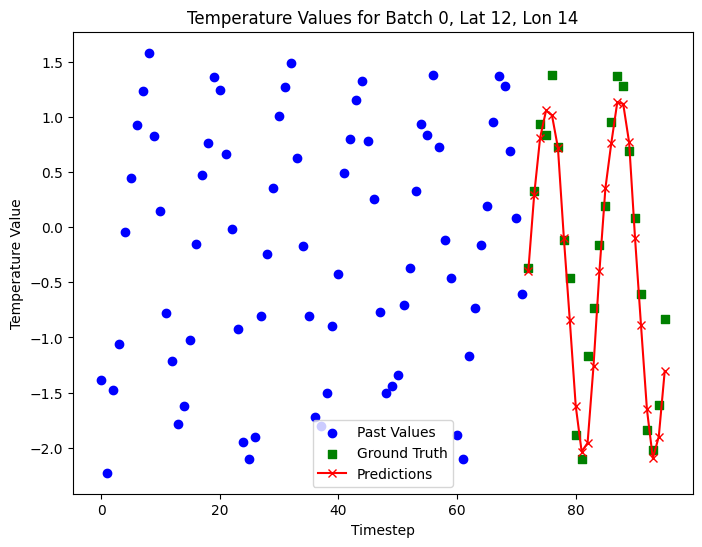

In [36]:
import torch
import matplotlib.pyplot as plt

def plot_temperature_values(loader, predictions, input_width, output_width, batch_idx=0, lat_idx=0, lon_idx=0):

    # Extract data for past timesteps
    past_data = loader[0]
    
    past_temperatures = past_data[batch_idx, :, -1, lat_idx, lon_idx]

    # Extract ground truth data for future timesteps
    ground_truth_data = loader[1]
    ground_truth_temperatures = ground_truth_data[batch_idx, :, lat_idx, lon_idx]

    # Extract prediction data
    prediction_temperatures = predictions.detach().numpy()[batch_idx, :, lat_idx, lon_idx]

    # Create timesteps for plotting
    timesteps_past = list(range(input_width))
    timesteps_future = list(range(input_width, input_width + output_width))
    print(len(timesteps_future))

    # Create scatter plot
    plt.scatter(timesteps_past, past_temperatures, c='blue', marker='o', label='Past Values')
    plt.scatter(timesteps_future, ground_truth_temperatures, c='green', marker='s', label='Ground Truth')
    plt.plot(timesteps_future, prediction_temperatures, c='red', marker='x', label='Predictions')

    plt.xlabel('Timestep')
    plt.ylabel('Temperature Value')
    plt.title(f'Temperature Values for Batch {batch_idx}, Lat {lat_idx}, Lon {lon_idx}')
    plt.legend()
    plt.show()

# Usage:
loader = next(iter(test_loader))
predictions = model_3(loader[0])
plot_temperature_values(loader, predictions, input_width, output_width, lat_idx=12, lon_idx=14)